# Creación de embeddings textuales

Para crear embedding utilizaremos una versión básica del algoritmo de Word2Vec. En esta implementación, se utiliza una red neuronal feedfoward con una capa oculta y una capa de salida, esta última con activación Softmax.

## Preparación de los datos

En primer lugar, definimos las bibliotecas y paquetes necesarios

In [0]:
import numpy as np
from collections import defaultdict, Counter
from operator import itemgetter
from itertools import chain, permutations
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from itertools import chain
from re import sub
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from operator import itemgetter
from tqdm import tqdm

Podemos usar una lista de paro (stopwords) para eliminar palabras que tienen poco interés (como artículos, preposiciones, conjunciones, etc.):

In [0]:
#Descarga lista de paro
nltk.download('stopwords')
#Asigna lista de paro para español
paro = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Ahora definimos un método de stemming, que se encargará de eliminar afijos en las palabras con el objetivo de reducir el número de tipos:

In [0]:
#Se define el stemer para español
stemizer = SnowballStemmer('spanish')
#Diccionario de bases y palabras
stem_list = defaultdict(set)

#Función para stemmizar
def stems(string):
  #Lista de stems
  stem_string = []
  for w in string.split():
    #Elimina stopwords
    if w in paro:
      pass
    else:
      #Aplica el stemer a cada palabra
      base = stemizer.stem(w)
      stem_string.append(base)
      #Se guardan las bases
      stem_list[base].add(w)
  return stem_string 

Definimos una función que obtiene los contextos: la idea es recorrer la cadena con una ventana de tamaño $2\cdot n$; es decir $n$ palabras a la izquierda y $n$ palabras a la derecha.

In [0]:
#Funcion para obtener las ventanas de contexto
def get_windows(string, windows_siz):
  contexts = []
  #El contexto es a la izq y a la der
  context_siz = 2*windows_siz
  #Si la sentencia es menor a la ventan, se conserva la sentencia
  if len(string) < context_siz:
    contexts.append(string)    
  #Si la sentencia es mayor a la ventana, se crean ventanas
  else:
    i = 0 
    #Añade los contextos
    while i+context_siz-1 < len(string):
      #Consigue los contextos
      contexts.append(string[i:i+context_siz])
      i += 1
  return contexts

Ahora definimos el vocabulario; en el vocabulario asignaremos un índice numérico a cada palabra; en lo que sigue, trabajaremos con los índices numéricos y no con las palabras:

In [0]:
#Define el vocabulario
voc = defaultdict()
#Define una función para agregar al vocabulario
#El nuevo elemento tomará el valor siguiente en voc
voc.default_factory = lambda: len(voc)

#Funcion de indexado
def get_data(data,windows_siz=1):
  for dat in data:
    string_text = stems(dat)
    #Stemizamos, y obtenemos las ventanas de contexto
    #Agregamos las palabras al vocabulario
    yield get_windows([voc[w] for w in string_text], windows_siz)

Ahora obtenemos el corpus, cargándolo desde Drive, y lo limpiamos:

In [0]:
from google.colab import files
upload = files.upload()

Saving corpus.es to corpus (4).es


In [0]:
corpus = upload['corpus.es'].decode('utf8')
#corpus = 'El perro come un hueso.\nUn muchacho jugaba.\nEl muchacho saltaba la cuerda!\nUn perro come croquetas'
#Strip y pasar todo a minúsculas
text = corpus.strip().lower()
#Limpiar el texto
cadenas = sub(r'[^\w\s]','',text).split('\n')[:100]

print(cadenas)

['un día una señora se emborrachó luego se fue a dormir a la casa de su vecino\r', 'depués ya se acostó y en la mañana se levantó se fue a casa\r', 'pero había muchísima neblina\r', 'y pasó por una sanja\r', 'se encontró una rana grandota\r', 'estaba grande\r', 'después se bajó dijo me lelvo esta rana para ir a almorzar porque no tengo nada para almorzar dijo\r', 'se fue entonces después este caminó como media parcela de la milpa que iba para su casa\r', 'le iba pesando la rana pesando pesando\r', 'cuando destapó su rebozo vio cuando estaba sentado un hombrecito chiquito era un charro muy grande\r', 'estaba sentado después en cuanto lo vio que estana sentado luego luego tiró el rebozo\r', 'luego tiró la rana\r', 'se cayó entonces el charrito\r', 'cuando lo tiró creció luego luego muy gande creció más que la señora\r', 'después ya desde ese momento ya no recuerda nada que es lo que hicieron el charro y la señora\r', 'pero sí vio al charro\r', 'pues creció muy rápido\r', 'después ya no r

Ahora aplicamos las funciones de get_data() para obtener los contextos:

In [0]:
#Obtiene los contexto de índices
cads_idx = list(get_data(cadenas,windows_siz=4))

print(cads_idx)

[[[0, 1, 2, 3, 4, 5, 6]], [[7, 8, 9, 10, 5]], [[11, 12]], [[13, 14]], [[15, 16, 17]], [[18]], [[19, 20, 21, 22, 16, 23, 24, 24], [20, 21, 22, 16, 23, 24, 24, 21]], [[25, 19, 26, 27, 28, 29, 30, 5]], [[30, 31, 16, 31, 31]], [[32, 33, 34, 35, 36, 37, 38, 18]], [[35, 19, 39, 34, 40, 35, 3, 3], [19, 39, 34, 40, 35, 3, 3, 41], [39, 34, 40, 35, 3, 3, 41, 33]], [[3, 41, 16]], [[42, 25, 43]], [[41, 44, 3, 3, 45, 44, 1]], [[19, 46, 47, 48, 38, 1]], [[34, 38]], [[49, 44, 50]], [[19, 47]], [[19, 51, 52]], [[19, 53, 54, 55, 25]], [[19, 56, 55]], [[19, 57, 58, 59, 59, 60, 61, 62]], [[61, 2]], [[49, 21, 30, 4, 5, 6]], [[61, 63, 64]], [[19, 59, 59, 65, 58, 58]], [[19, 59]], [[66, 67, 67, 59]], [[49, 15, 68]], [[19, 69, 70, 5, 71, 5, 72]], [[68, 73, 5, 71, 74, 75]], [[19, 76, 77, 78, 79, 80, 81, 77], [76, 77, 78, 79, 80, 81, 77, 82], [77, 78, 79, 80, 81, 77, 82, 83]], [[19, 84, 85, 86]], [[68, 87, 13, 14]], [[16, 18, 16]], [[88, 89, 16, 90]], [[91, 92, 31, 65, 93]], [[19, 91, 16, 91, 49, 25, 94, 26], 

Finalmente, a partir de los contextos, obtenemos los pares de entrenamiento:

In [0]:
#Obtenemos los ejemplos para entrenar la red
ejemplos = list(chain(*[list(permutations(cad,2)) for cad in chain(*cads_idx)]))
#Longitud del vocabulario
N = len(voc)

print(N)
print(len(ejemplos))

182
4134


## Red neuronal para entrenar embeddings

La arquitectura de la red es simple: toma un vector one-hot de entrada (que llamaremos $x$), cuenta con una capa oculta (capa de embedding) y, finalmente, toma una capa de salida con activación Softmax. La red no tiene bias en ninguna capa. En este sentido, podemos ver las operaciones de la red como:

* Capa de embedding: $$h = Ux$$
* Capa de salida: $$f(x) = Softmax(Vh)$$

Definiremos las matrices $U$ (de embedding) y $V$ (de la capa de salida), donde la primera es de $N\times d$ (número de palabras por dimensiones del embedding) y la última es de $d\times N$ (dimensiones del embedding por número de palabras). Cada una se inicia aleatoria e independientemente.





In [0]:
np.random.seed(0)
#Dimensiones de los vectores-palabra
dim = 100

#Embedding
U = np.random.randn(dim, N) / np.sqrt(N)
#Capa de salida
V = np.random.randn(N,dim) / np.sqrt(dim)

Para entrenar usamos el algoritmo de SGD, retropropagando el error. La función de pérdida está definida como:

$$L(\theta) = -\sum_i \sum_j y_{ij} \log f_j(x_i) $$

Donde $y_{ij}$ es 1 si la salida corresponde a la palabra en contexto, y 0 en otro caso.

In [0]:
#Número de iteraciones
its = 100
#Valor del rango de aprendizjae
eta = 0.1

#Comienza entrenamiento
for i in tqdm(range(0,its)):

    for ex in ejemplos:
        #FORWARD
        #Embedimiento
        u_w = U.T[ex[0]]
        #salida
        a = np.dot(V,u_w)
        #Se resta el máximo para evitar overflow
        out = np.exp(a - np.max(a))
        #Softmax
        f = out/out.sum(0)
        

        #BACKPROP
        #Variable de salida
        d_out = f
        d_out[ex[1]] -= 1
        
        #Variable de embedding
        d_emb = np.dot(d_out,V)
        
        #Actualizacion de salida
        V -= eta*np.outer(d_out,u_w)

        #Actualizacion de embedding
        U.T[ex[0]] -= eta*d_emb        

100%|██████████| 100/100 [00:52<00:00,  1.94it/s]


## Representación de las palabras en espacio vectorial

Finalmente, podemos ver las representaciones vectoriales de las palabras a través de los embeddings. Estos se ecuentran dentro de la matriz de embedding ($U$).

In [0]:
#Función para plotear en dos dimensiones con etiquetas
def plot_words(Z,ids):
    Z = PCA(n_components=2).fit_transform(Z)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    plt.show()

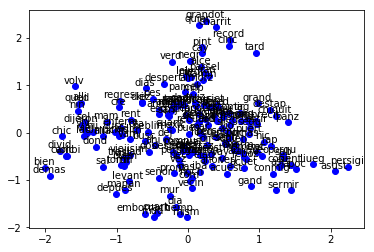

In [0]:
#Etiquetas (palabras)
label = [w[0] for w in sorted(voc.items(), key=itemgetter(1))]
#Plotea la imagen
plot_words(U.T,label)

Podemos comparar las palabras a partir de la cercanía de sus vectores a partir de una métrica o distancia definida en el espacio vectorial:

In [0]:
#Palabra que se quiere comparar
word = 'tortill'

euc = {}
for w in voc.keys():
  if w != word:
    #Obtiene los vectores palabra
    x = U.T[voc[word]]
    y = U.T[voc[w]]
    #Calucla la distancia eucludiana entre los vectores-palabra
    euc_dist = np.linalg.norm(x-y)    
    euc[w] = euc_dist

#Ordena de menor a mayor distancia las palabras
sort_euc = sorted(euc.items(), key=itemgetter(1))[:10]

for word,value in sort_euc:
  print(word, stem_list[word], value)

sal {'sal', 'salido'} 2.7402422638035735
com {'comer', 'cómo'} 2.809912381975715
dej {'dejé', 'dejaban', 'dejarla', 'dejar', 'dejamos'} 2.9558835015997964
cas {'casa'} 3.0677897110116716
quer {'quería'} 3.068616269239141
demas {'demás'} 3.07267960313881
mar {'marido'} 3.091531724712505
pascual {'pascuala'} 3.104955292571
mexic {'méxico'} 3.108608557125946
despues {'después'} 3.1656753930657797
